In [4]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.metrics import classification_report
import spacy
import os

In [5]:
data_files = [f for f in os.listdir("data") if f.endswith(".csv")]
df = pd.concat([pd.read_csv(f"data/{f}") for f in data_files])

In [6]:
df.head()

,essay_id,text,label,source,prompt,fold,id,llm_text
0,E897534557AF,"In recent years, technology has had a profoun...",1.0,mistral7binstruct_v2,\nTask: Write an essay discussing the positive...,1.0,NaN,NaN
1,DFBA34FFE11D,Should students participate in an extracurricu...,0.0,persuade_corpus,NaN,2.0,NaN,NaN
2,af37ecf5,The electoral college is a symbol of mockery a...,0.0,train_essays,NaN,5.0,NaN,NaN
3,5EC2696BAD78,This is why I think the principle should allow...,0.0,persuade_corpus,NaN,8.0,NaN,NaN
4,llama_70b_v1843,I strongly believe that meditation and mindful...,1.0,llama_70b_v1,Some schools have implemented meditation and m...,0.0,NaN,NaN


# Preprocess data

In [7]:
def preprocess(_df):
    def average(list_of_numbers):
        return sum(list_of_numbers) / len(list_of_numbers)
    _df["len_text"] = _df["text"].apply(lambda x: len(x))
    _df["n_tokens"] = _df["text"].apply(lambda x: len(x.split()))
    _df["avg_len_token"] = _df["text"].apply(lambda x: average([len(t) for t in x.split()]))

    nlp = spacy.load("en_core_web_sm")

    def convert_to_pos_tags(text):
        return " ".join([token.pos_ for token in nlp(text)])


    _df["pos"] = _df["text"].apply(convert_to_pos_tags)
    return _df

# df = preprocess(df)

df = pd.read_csv("all_data.csv")


/var/folders/vf/4t46plyn5x31c94wb535ryhw0000gq/T/ipykernel_94654/376660595.py:19: DtypeWarning: Columns (1,5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("all_data.csv")


# Split train/test


In [8]:
df["dataset"] = "train"
dfupdate=df.sample(frac=.3)
dfupdate["dataset"]="test"
df.update(dfupdate)

In [9]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, MinMaxScaler

class ItemSelector(BaseEstimator, TransformerMixin):
    ''' Class that enables the possibility to select words in the training pipeline
    '''

    def __init__(self, key):
        self.key = key

    def fit(self, x, y=None):
        return self

    def transform(self, data_dict):
        return data_dict[self.key]


class ItemSelectorNumerical(BaseEstimator, TransformerMixin):
    ''' Class that enables the possibility to select numerical words in the training pipeline
    '''

    def __init__(self, key):
        self.key = key

    def fit(self, x, y=None):
        return self

    def transform(self, data_dict):
        return [[v,] for v in data_dict[self.key].tolist()]
    


In [57]:
pipeline = Pipeline([
    ('union', FeatureUnion(n_jobs=-1,
        transformer_list=[
            ('n_tokens', Pipeline([
                ('selector', ItemSelectorNumerical(key='n_tokens')),
                ('scale', StandardScaler()),
            ])),
            ('avg_len_token', Pipeline([
                ('selector', ItemSelectorNumerical(key='avg_len_token')),
                ('scale', StandardScaler()),
            ])),
            ('pos_tags', Pipeline([
                ('selector', ItemSelector(key='pos')),
                ('vectorizer', TfidfVectorizer(ngram_range=(2,3), max_features=50)),
            ])),
            
        ]
    )),
    ('clf', tree.DecisionTreeClassifier(max_depth=3)),
])



In [58]:
pipeline.fit(df[df["dataset"] == "train"], df[df["dataset"] == "train"].label)

Pipeline(steps=[('union',
                 FeatureUnion(n_jobs=-1,
                              transformer_list=[('n_tokens',
                                                 Pipeline(steps=[('selector',
                                                                  ItemSelectorNumerical(key='n_tokens')),
                                                                 ('scale',
                                                                  StandardScaler())])),
                                                ('avg_len_token',
                                                 Pipeline(steps=[('selector',
                                                                  ItemSelectorNumerical(key='avg_len_token')),
                                                                 ('scale',
                                                                  StandardScaler())])),
                                                ('pos_tags',
                                                 Pipeline(steps=[('selector',
                                                                  ItemSelector(key='pos')),
                                                                 ('vectorizer',
                                                                  TfidfVectorizer(max_features=50,
                                                                                  ngram_range=(2,
                                                                                               3)))]))])),
                ('clf', DecisionTreeClassifier(max_depth=3))])

In [59]:
predictions = pipeline.predict(df[df["dataset"] == "test"])
print(classification_report(df[df["dataset"] == "test"].label, predictions))

              precision    recall  f1-score   support

           0       0.90      0.95      0.92     34618
           1       0.84      0.71      0.77     13219

    accuracy                           0.88     47837
   macro avg       0.87      0.83      0.85     47837
weighted avg       0.88      0.88      0.88     47837



In [60]:
feature_names = ["avg_tokens", "avg_len_tokens"] + (list(pipeline["union"]["pos_tags"]["vectorizer"].get_feature_names_out()))
print(feature_names)

['avg_tokens', 'avg_len_tokens', 'adj noun', 'adj noun adp', 'adj noun punct', 'adp det', 'adp det noun', 'adp noun', 'adp noun punct', 'adp pron', 'adv verb', 'aux adj', 'aux adv', 'aux part', 'aux verb', 'cconj verb', 'det adj', 'det adj noun', 'det noun', 'det noun adp', 'det noun punct', 'noun adp', 'noun adp det', 'noun adp noun', 'noun aux', 'noun aux verb', 'noun cconj', 'noun noun', 'noun part', 'noun pron', 'noun punct', 'noun punct pron', 'noun verb', 'part verb', 'pron aux', 'pron aux verb', 'pron noun', 'pron verb', 'punct cconj', 'punct noun', 'punct pron', 'punct pron aux', 'punct space', 'sconj pron', 'verb adj', 'verb adp', 'verb det', 'verb det noun', 'verb noun', 'verb part', 'verb pron', 'verb punct']


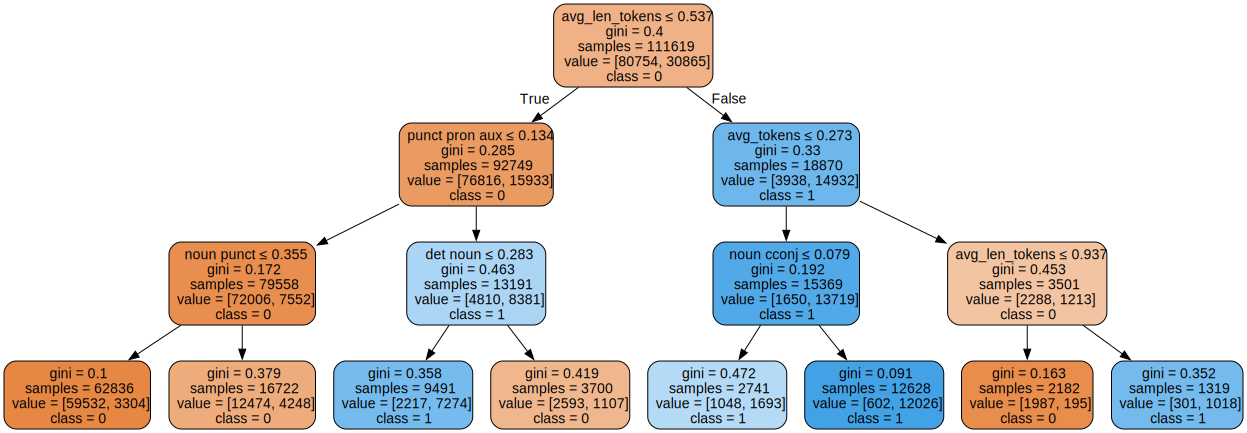

In [61]:
import graphviz
dot_data = tree.export_graphviz(pipeline["clf"], out_file=None, 
                     feature_names=feature_names,  
                     class_names=["0","1"]  ,
                     filled=True, rounded=True,  
                      special_characters=True)  
graph = graphviz.Source(dot_data)  
graph 

# Test on Validation set

In [62]:
df_validation = pd.read_csv("data/llm_essays.csv")
df_validation["text"] = df_validation["llm_text"]

In [63]:
df_validation = preprocess(df_validation)
df_validation.head()

,id,prompt,llm_text,text,len_text,n_tokens,avg_len_token,pos
0,423A1CA112E2,"given the following essay, write a similar ess...","Devices\n\nIn contemporary society, individual...","Devices\n\nIn contemporary society, individual...",2193,303,6.224422,NOUN SPACE ADP ADJ NOUN PUNCT NOUN AUX ADV VER...
1,BC75783F96E3,"given the following essay, write a similar ess...",This exposition delves into the debate surroun...,This exposition delves into the debate surroun...,1887,278,5.769784,DET NOUN VERB ADP DET NOUN VERB SCONJ NOUN AUX...
2,74C8BC7417DE,"given the following essay, write a similar ess...",Operating a vehicle while engaging with cellul...,Operating a vehicle while engaging with cellul...,1552,222,5.981982,VERB DET NOUN SCONJ VERB ADP ADJ NOUN AUX VERB...
3,A8445CABFECE,"given the following essay, write a similar ess...",Mobile Devices and Road Safety\n\nIt is impera...,Mobile Devices and Road Safety\n\nIt is impera...,1630,246,5.613821,PROPN PROPN CCONJ PROPN PROPN SPACE PRON AUX A...
4,6B4F7A0165B9,"given the following essay, write a similar ess...",The Evolution of Communication Devices in Rela...,The Evolution of Communication Devices in Rela...,1896,275,5.883636,DET PROPN ADP PROPN PROPN ADP PROPN ADP PROPN ...


In [64]:

val_predictions = pipeline.predict(df_validation)
y_validation = [1 ]* len(val_predictions)
print(classification_report(y_validation, val_predictions))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00         9

    accuracy                           1.00         9
   macro avg       1.00      1.00      1.00         9
weighted avg       1.00      1.00      1.00         9

